<a href="https://colab.research.google.com/github/ElZho/Graduation-project-Predict-Disaster-tweets/blob/main/Bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 13.1 MB/s 
     |████████████████████████████████| 895 kB 29.1 MB/s 
     |████████████████████████████████| 67 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 22.1 MB/s 
     |████████████████████████████████| 6.5 MB 45.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Построим модель на базе модели использованной на уроке по NLP

Imports

In [ ]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from numpy.ma.core import shape
from transformers import AdamW
from transformers.models import bert
import time

**Какую модель будем использовать??? !!!**

---

⛳

Будем выбрать в зависимости от используемой модели и вставить в следующую ячейку:

* Bert-base-uncased 12 layer 768 нейронов
* Bert-large -uncased 24 layer 1024 нерона

По бумагам по файнтюнинг лучшие показатели дает большая модель.

In [ ]:
#model_bert='bert-base-uncased'
model_bert='bert-large-uncased'

##Включаем GPU

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## Обучение, отрисовка результатов и предикт, обработка аналитик обучения **обернуты в функции**

Отрисовка графиков

In [ ]:
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20,7))

    plt.subplot(1,3,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

    plt.subplot(1,3,3)
    plt.title('F1 score', fontsize=15)
    plt.plot(history['f1']['train'], label='train')
    plt.plot(history['f1']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import f1_score

Трайн

In [ ]:
def train(
    model,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''
    
    history = defaultdict(lambda: defaultdict(list))

    for epoch in tqdm(range(num_epochs), desc='epochs'):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_f1=0
        val_f1=0
        
        start_time = time.time()

        model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, mask_batch, y_batch in tqdm(
            train_batch_gen, desc='train sample batches'
        ):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            mask_batch = mask_batch.to(device)
            y_batch = y_batch.to(device)
           
            model_output = model(X_batch, mask_batch, labels=y_batch)
            # print(model_output)
            loss = model_output.loss
            logits = model_output.logits
            
            loss.backward()
            optimizer.step()
            
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            train_f1+=f1_score(y_batch.cpu().numpy(), y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        train_f1/= len(train_batch_gen)
        
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        history['f1']['train'].append(train_f1)
    
        model.train(False) # устанавливаем поведение dropout / batch_norm  в тестирование

        # Полный проход по валидации    
        for X_batch, mask_batch, y_batch in tqdm(
            val_batch_gen, desc='validation sample batches'
        ):
            X_batch = X_batch.to(device)
            mask_batch = mask_batch.to(device)
            y_batch = y_batch.to(device)
            
            # При использовании .no_grad() модель не будет считать и хранить градиенты.
            # Это ускорит процесс предсказания меток для тестовых данных.
            with torch.no_grad():
                model_output = model(X_batch, mask_batch, labels=y_batch)
                loss = model_output.loss
                logits = model_output.logits
            
            val_loss += np.sum(loss.detach().cpu().numpy())
            
            # применяем функцию max к каждому логиту из батча
            # функция max возвращает две величины: значения и индексы
            # выбираем индексы
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            val_f1=f1_score(y_batch.cpu().numpy(), y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        val_f1/= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        history['f1']['val'].append(val_f1)
        # шаг шедуллера
        scheduler.step(val_loss)
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  training f1: \t\t\t{:.2f} %".format(train_f1 * 100))
        print("  validation f1: \t\t\t{:.2f} %".format(val_f1 * 100))
        
        if epoch > 0:
          plot_learning_curves(history)
        
    return model, history

Предикт

In [ ]:
def predict_disaster(model, test_dataloader):
  model.eval()
  test_preds, test_labels = [], []

  for X_batch, mask_batch in tqdm(test_dataloader):
      X_batch = X_batch.to(device)
      mask_batch = mask_batch.to(device)
      
      # При использовании .no_grad() модель не будет считать и хранить градиенты.
      # Это ускорит процесс предсказания меток для тестовых данных.
      with torch.no_grad():
          logits = model(X_batch, mask_batch).logits
          
      # применяем функцию max к каждому логиту из батча
      # функция max возвращает две величины: значения и индексы
      # выбираем индексы
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      
      test_preds.extend(y_pred)
  return test_preds    

Обработка аналитик

In [ ]:
def handle_history(history):
  df=pd.DataFrame(history)
  itog=pd.DataFrame()
  list_itog=[]
  s=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'train_f1', 'val_f1']
  n=0
  for i in range(2):
    for j in range(2):
      list_itog=df.iloc[i,j]
      itog[s[n]]=list_itog
      n+=1
  print(itog)
  return itog

## Поготовка данных

In [ ]:
%%time
tokenizer = BertTokenizer.from_pretrained(model_bert, do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

CPU times: user 429 ms, sys: 49.1 ms, total: 478 ms
Wall time: 4.78 s


In [ ]:
def make_bert_token(data, tweets, MAX_LEN, n=7389, test_size=0.2, batch_size = 10):
  tokenized_sentences = [tokenizer.tokenize(sent) for sent in tqdm(tweets)]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_sentences)]
  token_lens = [len(sent) for sent in tqdm(input_ids)]
  tokenizer.convert_tokens_to_ids("[PAD]")
  padding = lambda texts: pad_sequences(texts, 
                                      maxlen=MAX_LEN, 
                                      dtype="long", 
                                      truncating="post", 
                                      padding="post"
                                     )

  # применяем padding и truncation ко входным данным
  input_ids = padding(input_ids)
  get_attention_masks = lambda input_ids: [[float(i>0) for i in seq] for seq in input_ids]
  attention_masks = get_attention_masks(input_ids)
  labels=data[:n].target.astype(int)
  X_train, X_val, mask_train,\
                mask_val, y_train, y_val = train_test_split(input_ids[:n], 
                                               attention_masks[:n], labels,
                                               test_size=test_size, 
                                               random_state=42, shuffle=True)
  X_test=(input_ids[n:])
  mask_test= attention_masks[n:]
  X_train = torch.tensor(X_train)
  X_val = torch.tensor(X_val)
  X_test = torch.tensor(X_test)

  mask_train = torch.tensor(mask_train)
  mask_val = torch.tensor(mask_val)
  mask_test = torch.tensor(mask_test)

  y_train = torch.tensor(y_train.values)
  y_val = torch.tensor(y_val.values)   
  

  train_data = TensorDataset(X_train, mask_train, y_train)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  val_data = TensorDataset(X_val, mask_val, y_val)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


  test_data = TensorDataset(X_test, mask_test)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
  return train_dataloader, val_dataloader, test_dataloader



## Посмотрим на данные и определим длину текста (вернее токенов) сначала в text_unite

Это код до создания функции токенизации

In [ ]:
tokenized_sentences = [tokenizer.tokenize(sent) for sent in tqdm(clean_data.text_unite)]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_sentences)]

  0%|          | 0/10652 [00:00<?, ?it/s]

  0%|          | 0/10652 [00:00<?, ?it/s]

Смотрим на пример 

In [ ]:
example_sent=clean_data.text_unite[5]
print("Предложение:", example_sent)
tok = tokenizer.tokenize(example_sent)
print("Токенизация:", tok)
print("Индексы:    ", tokenizer.convert_tokens_to_ids(tok))

Предложение: The theme is   It is in   all residents asked to  shelter in place  are being notified by officers  no other evacuation or shelter in place orders are expected
Токенизация: ['the', 'theme', 'is', 'it', 'is', 'in', 'all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']
Индексы:     [1996, 4323, 2003, 2009, 2003, 1999, 2035, 3901, 2356, 2000, 7713, 1999, 2173, 2024, 2108, 19488, 2011, 3738, 2053, 2060, 13982, 2030, 7713, 1999, 2173, 4449, 2024, 3517]


Считаем длину предложений

In [ ]:
token_lens = [len(sent) for sent in tqdm(input_ids)]

  0%|          | 0/10652 [00:00<?, ?it/s]

In [ ]:
token_lens

Какую берем максимальную длину предложения?

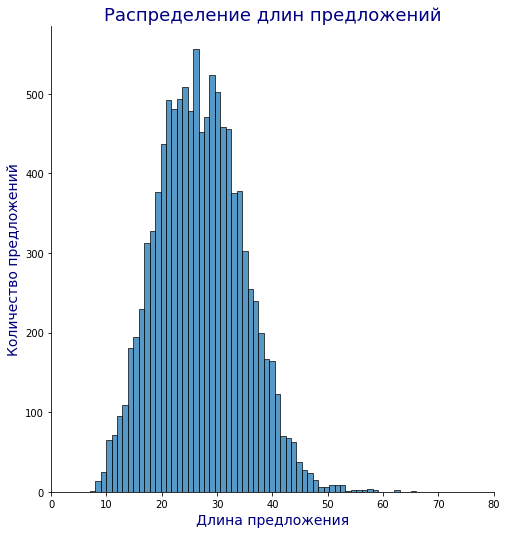

In [ ]:

ax=sns.displot(token_lens, height=7, palette='ch:s=.25,rot=-.25')
plt.xlim([0, 80])
plt.xlabel('Длина предложения', size=14, color='navy')
plt.ylabel('Количество предложений', size=14, color='navy')
plt.title('Распределение длин предложений', size=18, color='navy', y=1.05)
plt.show();


Для объединенного столбца целесообразно использовать длину столбца 46

## Посмотрим на длину предложения столбца text

Токенизируем

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

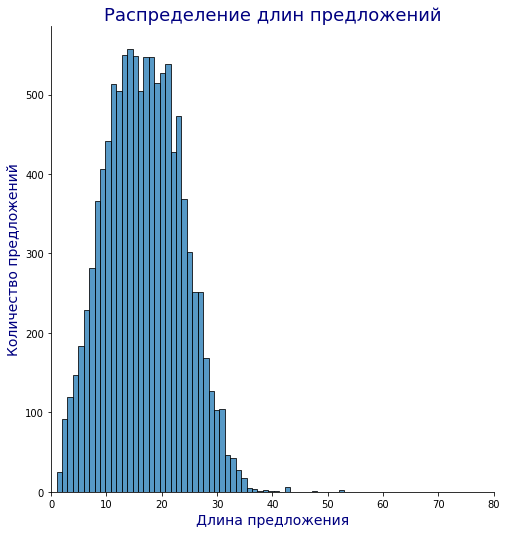

In [ ]:
tokenized_sentences = [tokenizer.tokenize(sent) for sent in tqdm(clean_data.text)]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_sentences)]
token_lens = [len(sent) for sent in tqdm(input_ids)]
ax=sns.displot(token_lens, height=7, palette='ch:s=.25,rot=-.25')
plt.xlim([0, 80])
plt.xlabel('Длина предложения', size=14, color='navy')
plt.ylabel('Количество предложений', size=14, color='navy')
plt.title('Распределение длин предложений', size=18, color='navy', y=1.05)
plt.show();


В данном случае целлесообразно использовать 36 длину предложения

## Сделаем функцию для дата лоудера для валидационного набора, чтобы потом смотреть на confusion matrix и f1

In [ ]:
def make_validation(tweets, n=7613, max_len=46, test_size=0.2, batch_size=8):


  tokenized_sentences = [tokenizer.tokenize(sent) for sent in tqdm(tweets)]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_sentences)]
  token_lens = [len(sent) for sent in tqdm(input_ids)]
  tokenizer.convert_tokens_to_ids("[PAD]")
  padding = lambda texts: pad_sequences(texts, 
                                      maxlen=max_len, 
                                      dtype="long", 
                                      truncating="post", 
                                      padding="post"
                                     )

  # применяем padding и truncation ко входным данным
  input_ids = padding(input_ids)
  get_attention_masks = lambda input_ids: [[float(i>0) for i in seq] for seq in input_ids]
  attention_masks = get_attention_masks(input_ids)
  
  _, X_val, _,   mask_val = train_test_split(input_ids[:n], 
                                               attention_masks[:n], 
                                               test_size=test_size, 
                                               random_state=42, shuffle=True)
  
  X_val = torch.tensor(X_val)
  mask_val = torch.tensor(mask_val)
    
  val_data = TensorDataset(X_val, mask_val)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
  
  return val_dataloader
  

In [ ]:
len(input_ids)

1523

# Готовим модель для много разового использования.

Варианты использования
* Base
* Base + 1 layer
* Large
* Large + 1 layer.

Два варианта тестового столбца. Просто text или объединенные столбцы text, keyword, location

В последних версиях был добавлен lerning rate scheduler.

Делаем заготовку для многоразового использования. Сначала удаляем, то что уже создали

In [ ]:
del custom_model, optimazer

Проверяем, с какой будем работать

In [ ]:
model_bert

Загружаем нужную нам модель или загружаем ранее сохраненную

In [ ]:
custom_model = BertForSequenceClassification.from_pretrained(
    model_bert, num_labels=2
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
custom_model=torch.load('/content/drive/MyDrive/Classroom/Diplom/large_1l_best.pt')

Отправляем на GPU

Для базового варианта Берт использовала 64 нейрона на скром слое. Один дропаут - 0,05.

Для большого Берта использовала 64 нейрона на скрытом слое (пробовала разные варианты). Дропаут стразу после Берт и после линейного слоя 0,1 и 0,4. С 0,4 получился лучший вариант.
Softmax - не прижился

In [ ]:
imp_in= 768
hid_layer=64
#hid_layer_2=64
dr_out=0.1

custom_model_up=custom_model
custom_model.add_module('dp1', nn.Dropout(dr_out))
custom_model_up.add_module('linear1', nn.Linear(imp_in, hid_layer))
custom_model_up.add_module('bn1', nn.BatchNorm2d(hid_layer))
custom_model_up.add_module('dp1', nn.Dropout(dr_out))
custom_model_up.add_module('relu1', nn.ReLU())

# custom_model.add_module('linear1', nn.Linear(hid_layer, hid_layer_2))
# custom_model.add_module('bn1', nn.BatchNorm2d(hid_layer_2))
# custom_model.add_module('relu1', nn.ReLU())
# custom_model.add_module('dp1', nn.Dropout(dr_out))

custom_model_up.add_module('fc2', nn.Linear(hid_layer, 2))

custom_model = custom_model.to(device)

**Обязательно обновляем оптимайзер!**

---

⛳

Adam is a member of an algorithm class inspired by AdaGrad and introduces running averages of the first two gradient moments, mean and variance. Loshchilov and Hutter proposed a variation, AdamW, which decouples weight decay from gradient computation. 

Использовала  learning rate 2e-5 или 1e-6 для большой модели со слоями. 2e-5 - показал в исследованиях лучший результат. при 4e-4 - вообще нет сходимости. Поэтому у меня были проблемы со сходимостью при добавлении слоев в большую модель.
Добавление scheduler - в тех бумагах есть информацию об использование scheduler: We use slanted triangular learning rates . Я не успела разобраться с этим. Но попробовала scheduler, который уменьшает шаг, когда метрика перестает улучшаться. В качестве метрики загнала лос на валидационной выборке.
Модель large с 2 слоями, которая раньше не сходилась ни в какую, тут же начала сходиться.

In [ ]:
optimizer = AdamW(custom_model.parameters(), lr=2e-5)

#в последний момент добавила шедулер.
#scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Обрабатываем данные, готовим загрузчик
Данные: 7592
* augmented_df и 14781 строк train дата
* clean_data и 7613 полный или 7592 с удаленными столбцами train дата

In [ ]:
train_dataloader, val_dataloader, test_dataloader=make_bert_token(augmented_df, augmented_df.text_unite, MAX_LEN=64, n=14781, test_size=0.2, batch_size = 8)

  0%|          | 0/18044 [00:00<?, ?it/s]

  0%|          | 0/18044 [00:00<?, ?it/s]

  0%|          | 0/18044 [00:00<?, ?it/s]

Рекомендованное количество эпох для fine-tunning модели Берт - 2-4 эпохи. При большем количестве получается переобучение.

Однако при меньшем learning rate или при использование шедуллера, количество эпох можно увеличить. переобучения не будет.

Один из вариантов реализации. Это была большая модель с 1 слоем

Epoch 6 of 6 took 719.135s
  training loss (in-iteration): 	0.273137
  validation loss (in-iteration): 	0.443695
  training accuracy: 			89.72 %
  validation accuracy: 			83.32 %


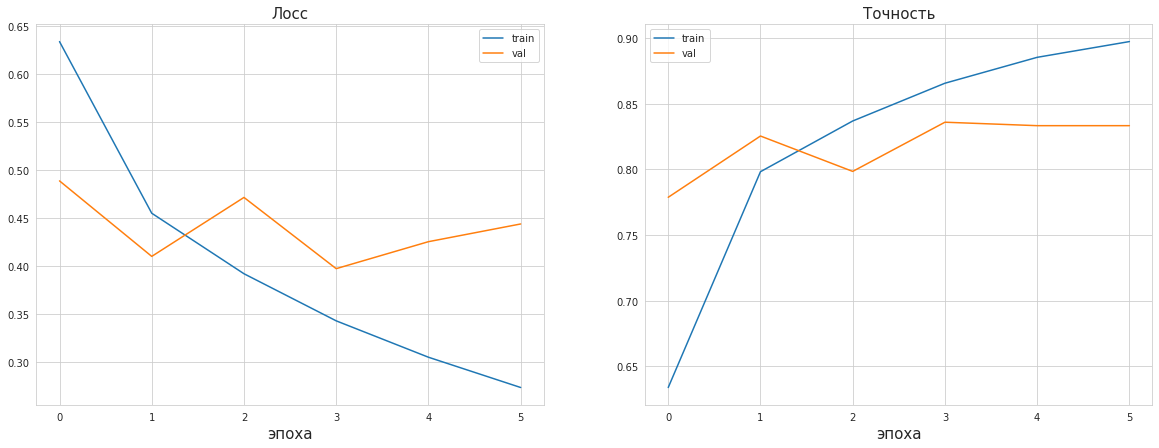

In [ ]:
custom_model, history = train(
    custom_model, optimizer, 
    train_dataloader, val_dataloader, 
    num_epochs=6
)

Обрабатываем аналитику по обучению

In [ ]:
itog= handle_history(history) 

   train_loss  train_acc  val_loss   val_acc
0    0.633910   0.633990  0.488625  0.778726
1    0.454889   0.798194  0.409883  0.825345
2    0.391787   0.836782  0.471367  0.798424
3    0.342652   0.865517  0.397086  0.835850
4    0.304717   0.885222  0.425219  0.833224
5    0.273137   0.897209  0.443695  0.833224


In [ ]:
test_preds=predict_disaster(custom_model, test_dataloader)    

  0%|          | 0/327 [00:00<?, ?it/s]

Сохраняем на диске отправляем в Kaggle

In [ ]:
data=pd.DataFrame()
data['id'] = clean_data[7613:].reset_index().id
data['target'] = test_preds

###Построим статистики и конфьюжен матрих

Для этого создадим даталоудер для валидационного набора

In [ ]:
val_pred_dataloader=make_validation(clean_data.text_unite, n=7613, max_len=46, test_size=0.2, batch_size=8)

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

Сделаем предсказание

In [ ]:
#make prediction on  validation datas
val_preds=test_preds=predict_disaster(custom_model, val_pred_dataloader)

  0%|          | 0/191 [00:00<?, ?it/s]

Посчитаем метрики

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

F1-score =  $ 2*( precision*recall)/$ $(recall+precission)$

In [ ]:
f1_score(y_val, val_preds)

0.7990468625893566

In [ ]:
import numpy as np
import itertools

In [ ]:
cm2=confusion_matrix(y_val, val_preds)
cm2

array([[767, 107],
       [146, 503]])

Text(0.5, 0, 'Predicted label')

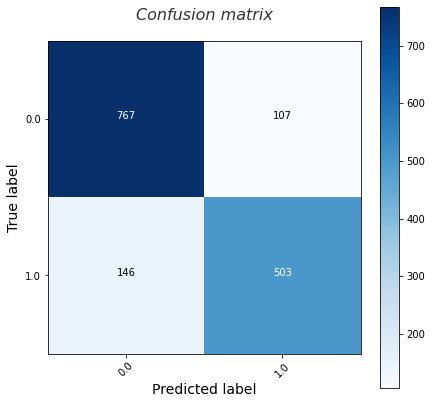

In [ ]:
  classes=[0., 1.0]
  plt.figure(figsize=(7,7))
  cmap=plt.cm.Blues
  thresh=cm2.max() / 2.
  plt.imshow(cm2, interpolation='nearest', cmap=cmap)
  plt.title('Confusion matrix', size = 16, y=1.05, fontstyle='oblique', color='0.2')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(j, i, cm2[i, j],
                 horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")
  plt.ylabel('True label', size = 14)
  plt.xlabel('Predicted label', size = 14)  

Очевидно, что мы хотим прежде всего минимизировать ошибку, где мы теряем целевые значения, т.е. FN. Неочень хорошо также FP иметь. Но в данной задаче это менее существенное значение имеет. Дальше необходимо проанализировать, почему возникают ошибки.

# Нарисуем аналитику всех вариантов

⛳ Опишем данные для всех графиков

In [ ]:
results=[bert_base_analyse_unite, bert_base_analyse, bert_base_analyse_unite_1L,
         bert_base_analyse_1L, bert_large_base_analyse_unite, bert_base_analyse_2l_unite,
         bert_large_analyse_1L_unite]  # список всех моделей для всех графиков!!!
legends=["Base model 3 text columns", "Base model one text column",\
         "Base model upgrade 3 text columns"," Base model upgrade one text column",\
         "Large base model 3 text columnse", "Base model upgrade 2layer 3 text columns",\
         "Bert_large_analyse_1L_unite smaller lr"] # Список всех легенд для моделей

Сначала построим overfitt

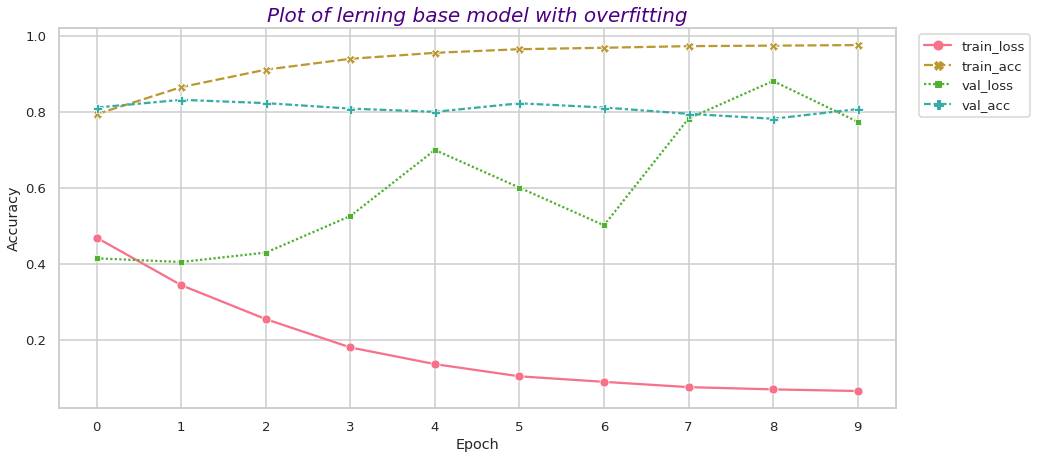

In [ ]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=0.8, \
        color_codes=False, palette='husl')
plt.figure(figsize=(15, 7))
data=  bert_base_text_overfit
ax=sns.lineplot(data=data, markers=True, legend='brief')
plt.legend(loc ='best', bbox_to_anchor = (1.02, 1.0), ncol = 1)  
ax.set_xticks(range(0, 10))
ax.set_xlabel('Epoch') 
ax.set_ylabel('Accuracy')
plt.title('Plot of lerning base model with overfitting', size=20, y=1., fontstyle='oblique', color='indigo' )
plt.show;


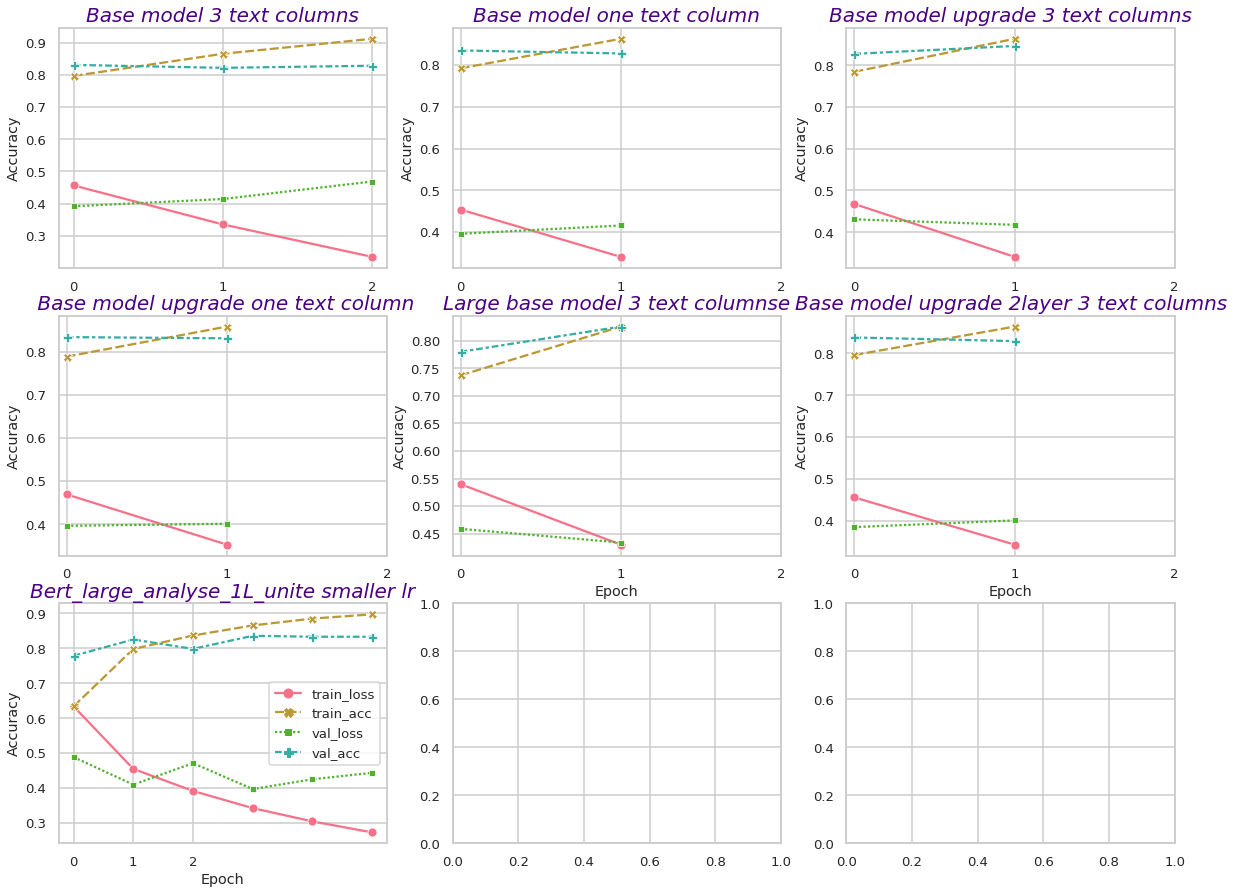

In [ ]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=0.8, \
        color_codes=False, palette='husl')

k=(len(results)//3+1)
fig, axis = plt.subplots(3, k, figsize=(20,k*5))


for i in range (len(results)):
  data=results[i]
  plt.subplot(k,3,i+1)
  if i ==len(results)-1:
    l='brief'
  else:
    l=False  
  ax=sns.lineplot(data=data, markers=True, legend=l)
  
 
  # plt.legend(loc ='best', bbox_to_anchor = (1.02, 1.0), ncol = 1)
  ax.set_xticks(range(0,3))
  if i<(len(results)-3):
    ax.set_xlabel('') 
  else:
    ax.set_xlabel('Epoch') 
  ax.set_ylabel('Accuracy')
  plt.title(legends[i], size=20, y=1., fontstyle='oblique', color='indigo' )
  plt.show;

